## OVERVIEW
---
* Data Visualization
* Storewise Analysis & Itemwise Analysis
* Stores Growth Factor Visualization
* Data Preprocessing 
* Hyperparameter Tuning with Bayesian Optimizer
* XGBoost to Forecast the Sales

In [ ]:
#VIZ LIBRARY
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm as tqdm
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

from plotly.offline import init_notebook_mode, iplot
import plotly_express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

pio.orca.config.executable = '/path/to/orca'
pio.orca.config.save()
#MODELS
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from bayes_opt import BayesianOptimization
import lightgbm as lgb

#STATS
import scipy
import statsmodels
from scipy import signal
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools

#METRICS
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report, r2_score,mean_absolute_error,mean_squared_error


import warnings 
warnings.filterwarnings('ignore')

In [2]:
#get the data
df_train  = pd.read_csv('data/train.csv')

## DATA BASIC INFORMATION
---

In [3]:
#dataset shape
print('TRAIN DATA SHAPE:   ', df_train.shape)

TRAIN DATA SHAPE:    (913000, 4)


In [4]:
df_train.head(3)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14


In [5]:
#convert time to pandas datetime object
df_train['date'] = pd.to_datetime(df_train['date']).dt.date

In [6]:
#show feature data types
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
date     913000 non-null object
store    913000 non-null int64
item     913000 non-null int64
sales    913000 non-null int64
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [7]:
#show basic stats info
df_train.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [8]:
#stats info by store
df_train.groupby('store').describe()

item                                                  sales  \
         count  mean        std  min   25%   50%   75%   max    count   
store                                                                   
1      91300.0  25.5  14.430949  1.0  13.0  25.5  38.0  50.0  91300.0   
2      91300.0  25.5  14.430949  1.0  13.0  25.5  38.0  50.0  91300.0   
3      91300.0  25.5  14.430949  1.0  13.0  25.5  38.0  50.0  91300.0   
4      91300.0  25.5  14.430949  1.0  13.0  25.5  38.0  50.0  91300.0   
5      91300.0  25.5  14.430949  1.0  13.0  25.5  38.0  50.0  91300.0   
6      91300.0  25.5  14.430949  1.0  13.0  25.5  38.0  50.0  91300.0   
7      91300.0  25.5  14.430949  1.0  13.0  25.5  38.0  50.0  91300.0   
8      91300.0  25.5  14.430949  1.0  13.0  25.5  38.0  50.0  91300.0   
9      91300.0  25.5  14.430949  1.0  13.0  25.5  38.0  50.0  91300.0   
10     91300.0  25.5  14.430949  1.0  13.0  25.5  38.0  50.0  91300.0   

                                                           
            mean        std  min   25%   50%   75%    max  
store                                                      
1      47.268379  24.006252  1.0  28.0  44.0  63.0  155.0  
2      67.033165  33.595810  3.0  40.0  62.0  89.0  231.0  
3      59.530602  29.974102  3.0  35.0  55.0  80.0  196.0  
4      54.902946  27.733097  4.0  32.0  51.0  73.0  186.0  
5      39.770164  20.365757  2.0  23.0  37.0  53.0  130.0  
6      39.733516  20.310451  0.0  23.0  37.0  53.0  134.0  
7      36.363735  18.684825  1.0  21.0  34.0  49.0  122.0  
8      64.142048  32.231751  4.0  38.0  60.0  86.0  204.0  
9      55.049025  27.832186  4.0  32.0  51.0  74.0  195.0  
10     58.709288  29.554994  3.0  35.0  54.0  78.0  187.0

In [9]:
#stats info by top 5 item with the highest average sales
df_train.groupby('item').describe().sort_values(('sales', 'mean'),ascending=False).head(5)

store                                            sales             \
        count mean      std  min  25%  50%  75%   max    count       mean   
item                                                                        
15    18260.0  5.5  2.87236  1.0  3.0  5.5  8.0  10.0  18260.0  88.030778   
28    18260.0  5.5  2.87236  1.0  3.0  5.5  8.0  10.0  18260.0  87.881325   
13    18260.0  5.5  2.87236  1.0  3.0  5.5  8.0  10.0  18260.0  84.316594   
18    18260.0  5.5  2.87236  1.0  3.0  5.5  8.0  10.0  18260.0  84.275794   
25    18260.0  5.5  2.87236  1.0  3.0  5.5  8.0  10.0  18260.0  80.686418   

                                                 
            std   min   25%   50%    75%    max  
item                                             
15    29.522852  17.0  66.0  85.0  108.0  231.0  
28    29.501781  16.0  66.0  85.0  107.0  206.0  
13    28.311031  20.0  63.0  81.0  103.0  210.0  
18    28.430621  18.0  63.0  81.0  103.0  208.0  
25    27.238817  18.0  60.0  78.0   99.0  193.0

### INSIGHTS
---
* Both Store 2 and Store 8 has the highest average sales.
* Item 12, 28, 13, 18 and 25 are the most popular items with highest average sales.

## EDA
---

### SALES DISTRIBUTION
---

In [10]:
# the maximum sale in the data is 231, so i divided the sales to five range categories
sales_distrib_df = df_train.copy()
sales_distrib_df['range'] = pd.cut(df_train.sales, [i*10 for i in range(26)]).values
sales_distrib_series = sales_distrib_df.groupby('range')['sales'].count()

Text(0, 0.5, 'Count')

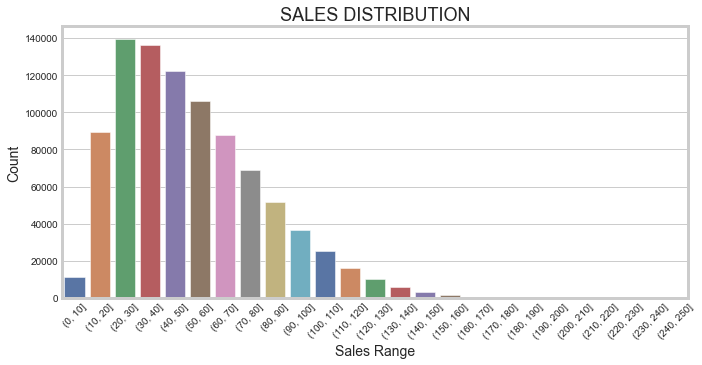

In [11]:
plt.figure(figsize =(10,5))
plt.xticks(rotation=45)
sns.barplot(x = sales_distrib_series.index, y=sales_distrib_series.values, palette='deep')
plt.title('SALES DISTRIBUTION', fontsize=18)
plt.xlabel('Sales Range', fontsize=14)
plt.ylabel('Count', fontsize=14)

Text(0.5, 0, 'Sales')

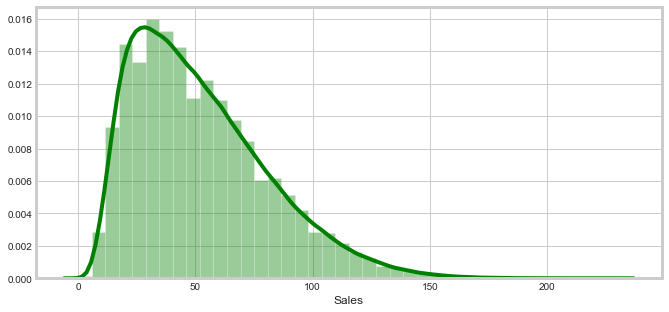

In [12]:
#show distribution plot with kde
plt.figure(figsize =(10,5))
sns.distplot(df_train['sales'],bins=40,color='green' )
plt.xlabel('Sales')

### INSIGHTS
---
* As we can see from the plots above, Most of  the sales value falls from range (0,50).
* The sales data distribution is positively skewed, which mean the measures are dispersed.
* The Distribution may be expressed as (Mean  >  Median  >  Mode).

### STORE SALES ANALYSIS
---

In [13]:
#create a new dataframe
sales_store_df = df_train.groupby(['date','store']).sum().reset_index()

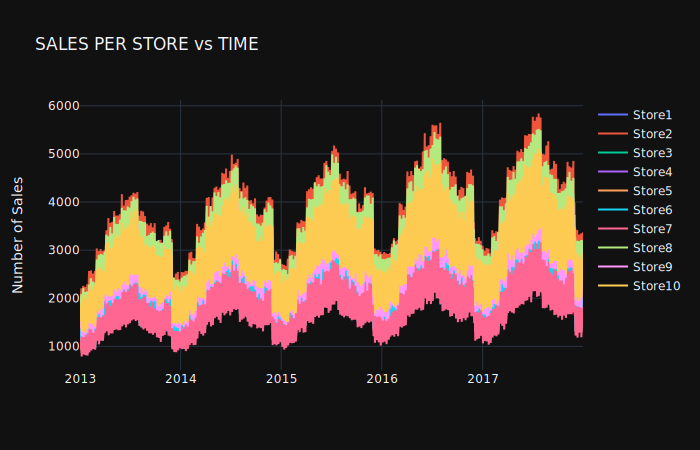

In [14]:
fig = go.Figure()

for i in range(10):
    sales = df_train[df_train['store'] ==(i+1)].groupby('date')['sales'].sum()
    fig.add_trace(go.Scatter(x=sales.index, y=sales.values, name = ('Store' + str(i+1))))

fig.update_layout(title='SALES PER STORE vs TIME', template='plotly_dark', height=400)
fig.update_yaxes(title='Number of Sales')
fig.show(renderer = 'svg')

### INSIGHTS
---
* We Can Clearly See a Pattern Here, the Wave is Oscilating and Around July and June the Sales Per Store Goes Up but Falls Around December and January

* Store 8 and Store 2 Has the Highest Sales Per Day

### AVERAGE SALES PER STORE
---

Text(0, 0.5, 'Mean Sales')

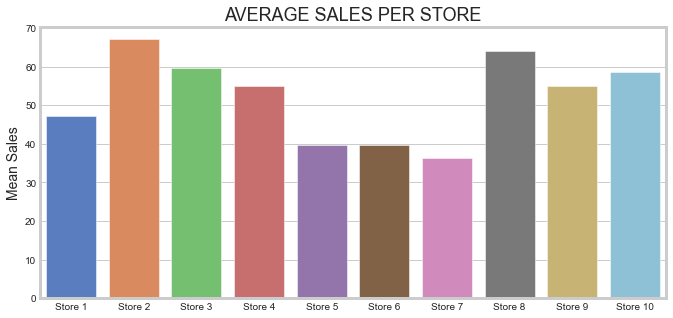

In [15]:
sales_store_df = pd.DataFrame(df_train.groupby('store')['sales'].mean()).reset_index(drop='ignore') 
stores = ['Store '+ str(store+1) for store in range(10)] 
plt.figure(figsize=(10,5)) 
sns.barplot(x =stores, y=sales_store_df.sales, palette='muted') 
plt.title('AVERAGE SALES PER STORE',fontsize=18) 
plt.ylabel('Mean Sales', fontsize=14)

* Here is the Mean sales per Store, as we can See Store 2 has the highest average sales and Store 7 has the Lowest.

### ITEM SALES ANALYSIS
---

In [16]:
sales_per_item = df_train.groupby(['date','item'])['sales'].sum().reset_index()

In [17]:
top_10_items = sales_per_item.groupby('item')['sales'].sum().sort_values(ascending=False).head(10)
print('TOP 10 ITEMS THAT HAS THE HIGHEST SALES\n')
for i in range(len(top_10_items.values)):
    print('ITEM ' + str(top_10_items.index[i]))

TOP 10 ITEMS THAT HAS THE HIGHEST SALES

ITEM 15
ITEM 28
ITEM 13
ITEM 18
ITEM 25
ITEM 45
ITEM 38
ITEM 22
ITEM 36
ITEM 8


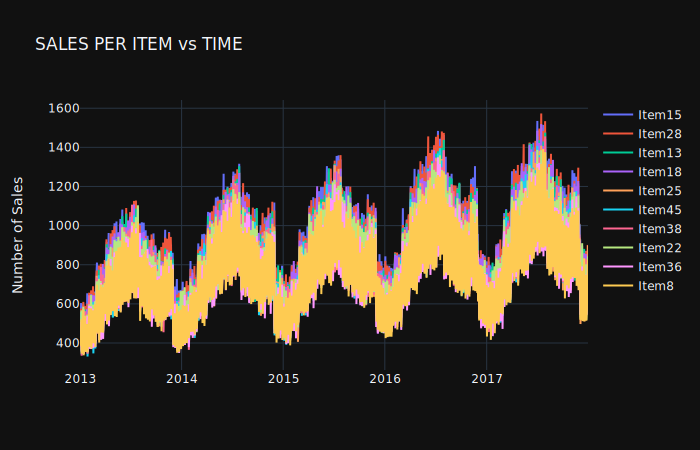

In [19]:
fig = go.Figure()

for i in top_10_items.index:
    sales = sales_per_item[sales_per_item['item'] ==(i)].groupby('date')['sales'].sum()
    fig.add_trace(go.Scatter(x=sales.index, y=sales.values, name = ('Item' + str(i))))

fig.update_layout(title='SALES PER ITEM vs TIME', template='plotly_dark', height=400)
fig.update_yaxes(title='Number of Sales')
fig.show(renderer='svg')

### INSIGHTS
---
* Time-series graph of top 10 items, the trend is the same as the sales per store.
* The actual sale value per item consistently varies with the same scale
* Around july the sales per item goes up but began to fall around december
* Item 15 has the number of sales here

### AVERAGE SALES PER ITEM
---

Text(0, 0.5, 'Sales Mean')

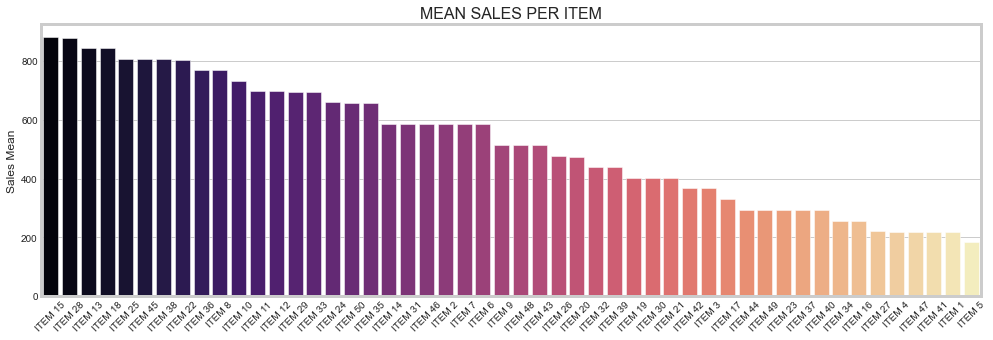

In [20]:
items_mean_sales = sales_per_item.groupby('item')['sales'].mean().sort_values(ascending=False)
item_no = ['ITEM ' + str(item) for item in items_mean_sales.index]
##the actual sale value consitently varies with the same scale.
plt.figure(figsize=(15,5))
sns.barplot(x=item_no, y=items_mean_sales.values, palette='magma')
plt.xticks(rotation=45)
plt.title('MEAN SALES PER ITEM', fontsize=16)
plt.ylabel('Sales Mean', fontsize=12)

* Mean sales per item, Item 28 has the highest mean which is 800 and item 5 with the lowest mean which is 186

### STORES GROWTH FACTOR
---

In [21]:
#create a new data frame
gf_data = df_train.groupby(['date','store']).sum()
gf_data = gf_data.reset_index(level=1)

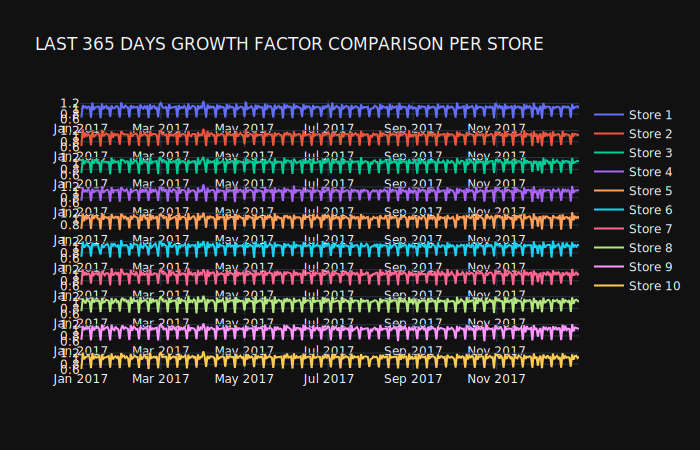

In [25]:
fig = make_subplots(10,1)

for i in range(1,11):
    store_num = gf_data[gf_data['store'] ==(i)].groupby('date')['sales'].sum()[-365:]
    fig.add_trace(go.Scatter(x=store_num.index, y=(store_num.values/ store_num.shift()),
                             name = ('Store ' + str(i))), row=i, col=1)

fig.update_layout(title='LAST 365 DAYS GROWTH FACTOR COMPARISON PER STORE', template='plotly_dark', height=1500)
fig.show(renderer='svg')

### INSIGHTS
---
* From the figure above, we can see that the plots are oscillating, which means there is a trend. 
* Most of the stores has the same growth pattern.


## FORECASTING SECTION
---

### DATA PREPROCESSING
---

In [167]:
#extract the date
df_train['day']=pd.to_datetime(df_train['date']).dt.day
df_train['weekofyear']=pd.to_datetime(df_train['date']).dt.weekofyear
df_train['dayofweek']=pd.to_datetime(df_train['date']).dt.dayofweek
df_train['month']=pd.to_datetime(df_train['date']).dt.month
df_train['year']=pd.to_datetime(df_train['date']).dt.year

In [179]:
#separate the targets
X = df_train.drop(['date', 'sales'],axis=1)
y = df_train['sales']

#split the data
#i will separate the last 365 days data and assign them as test data
X_train, X_test = X[:-365], X[-365:]
y_train, y_test = y[:-365], y[-365:]

### XGBOOST
---

#### HYPERPARAMETER TUNING (BAYESIAN OPTIMIZER)

In [191]:
#convert the train and test data to DMatrix form of XGB
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

In [217]:
#create the optimizer function (note: this optimizer contains lgb and xgb paramaters, by using xgboost)
def bayes_parameter_opt_lgb(X, y, init_round=2, opt_round=4, n_folds=5, random_seed=6, n_estimators=3, learning_rate=0.02, output_process=False):
    # prepare data
    train_data = lgb.Dataset(data=X, label=y)
    # parameters
    def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight, colsample_bytree, gamma):
        params = {'application':'regression_l1','num_iterations': n_estimators, 'learning_rate':learning_rate, 'early_stopping_round':100, 'metric':'auc'}
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        params['subsample'] = 0.8
        params['eta'] = 0.1
        params['gamma'] = gamma
        params['colsample_bytree'] = colsample_bytree
        
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
        return max(cv_result['auc-mean'])
    # range 
    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (24, 45),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.8, 1),
                                            'max_depth': (5, 8.99),
                                            'lambda_l1': (0, 5),
                                            'lambda_l2': (0, 3),
                                            'min_split_gain': (0.001, 0.1),
                                            'min_child_weight': (5, 50),
                                            'colsample_bytree': (0.3, 0.9),
                                            'gamma': (0, 1)},random_state=0)

    # optimize
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    # output optimization process
    if output_process==True: lgbBO.points_to_csv("bayes_opt_result.csv")
    
    # return best parameters
    return lgbBO.max

In [218]:
#run the optimizer
opt_params = bayes_parameter_opt_lgb(X_train, y_train)

|   iter    |  target   | baggin... | colsam... | featur... |   gamma   | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.9999   |  0.9098   |  0.7291   |  0.5822   |  0.5449   |  2.118    |  1.938    |  6.746    |  45.13    |  0.0964   |  32.05    |
|  2        |  0.9998   |  0.9583   |  0.6173   |  0.5544   |  0.9256   |  0.3552   |  0.2614   |  5.081    |  42.47    |  0.07804  |  42.27    |
|  3        |  0.9998   |  0.8342   |  0.5771   |  0.4139   |  0.5164   |  4.999    |  1.7      |  8.548    |  5.082    |  0.08382  |  24.5     |
|  4        |  0.9999   |  0.8246   |  0.6008   |  0.6799   |  0.1457   |  1.901    |  1.743    |  7.65     |  5.102    |  0.02711  |  44.95    |
|  5        |  0.9999   |  0.9387   |  0.5572   |  0.6241   |  0.9402   |  2.876    |  2.772    |  5.002    |  49.96    |  0

In [219]:
#get the best hyperparameters
params = opt_params['params']
params['max_depth'] = int(round(params['max_depth']))
params['num_leaves'] = int(round(params['num_leaves']))

In [ ]:
#train the model
model = xgb.train(params, dtrain, num_boost_round=250)

In [221]:
#predict the test data
predictions = model.predict(dtest)

#### TRUE VALUE AND PREDICTION COMPARISON

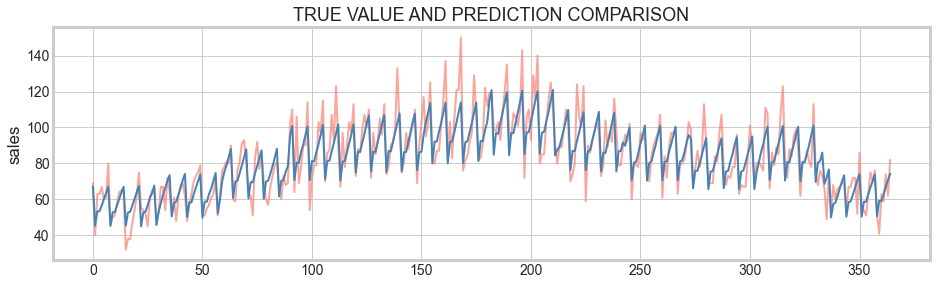

In [228]:

plt.figure(figsize=(14,4))
plt.title('TRUE VALUE AND PREDICTION COMPARISON', fontsize=18)
sns.lineplot(np.arange(len(y_test)), y_test, color='salmon', lw=2, alpha=0.7)
sns.lineplot(np.arange(len(y_test)), predictions, color='steelblue', lw=2)

#### (MAE, MSE, RMSE)

In [229]:
xgb_mae = mean_absolute_error(y_test, predictions)
xgb_mse = mean_squared_error(y_test, predictions)
xgb_rmse = np.sqrt(mean_squared_error(y_test, predictions))

print('Mean Absolute Error:   ', xgb_mae)
print('Mean Squared Error:   ', xgb_mse)
print('Root Mean Squared Error:   ', xgb_rmse)


Mean Absolute Error:    6.980851620190764
Mean Squared Error:    82.7681122539545
Root Mean Squared Error:    9.09769818437359


#### MEAN ABSOLUTE PERCENTAGE ERROR

In [231]:
xgb_error_rate = abs(((y_test - predictions) / y_test).mean()) * 100
print('MAPE:', round(xgb_error_rate,2), '%')

MAPE: 0.87 %


#### R-SQUARED SCORE

In [233]:
print('R-SQUARED SCORE: ', round(r2_score(y_test, predictions),2)*100, '%')

R-SQUARED SCORE:  81.0 %
